<a href="https://colab.research.google.com/github/Ksenyff/AI/blob/main/CameraCalibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving marker.png to marker (2).png


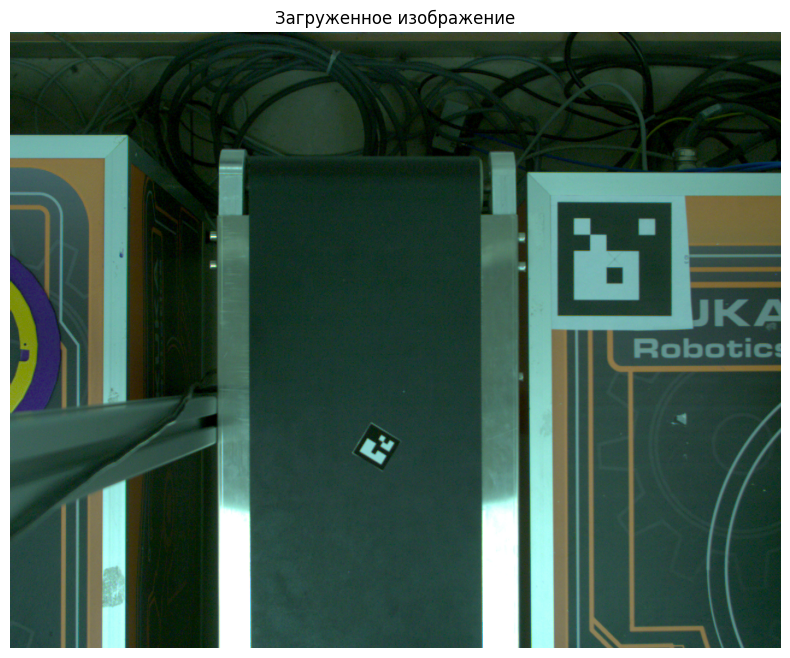

✅ Найден маркер с помощью словаря: 6
Маркер ID=3: центр (1003, 377)
Маркер ID=15: центр (608, 689)


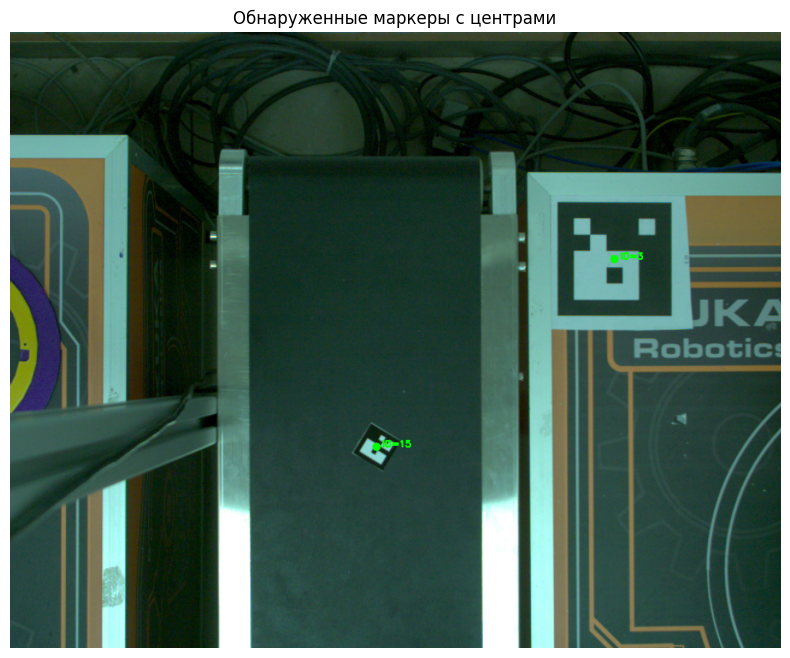

In [5]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Загрузка изображения ---
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]
img = cv2.imread(image_filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.title("Загруженное изображение")
plt.axis('off')
plt.show()

# --- Настройка ArUco ---
# Попробуем несколько словарей — если один не работает, попробуем другой
aruco_dicts = [
    cv2.aruco.DICT_6X6_250,
    cv2.aruco.DICT_5X5_250,
    cv2.aruco.DICT_4X4_250,
    cv2.aruco.DICT_APRILTAG_16h5
]

found = False
for aruco_dict in aruco_dicts:
    detector = cv2.aruco.ArucoDetector(cv2.aruco.getPredefinedDictionary(aruco_dict), cv2.aruco.DetectorParameters())
    corners, ids, rejected = detector.detectMarkers(img)

    if ids is not None:
        print(f"✅ Найден маркер с помощью словаря: {aruco_dict}")
        found = True
        break

if not found:
    print("❌ Маркер не найден ни с одним из словарей.")
    print("Попробуйте вручную указать координаты или проверьте качество изображения.")
else:
    # Выводим информацию о найденных маркерах
    for i in range(len(ids)):
        pts = corners[i][0]  # Координаты углов маркера
        center_x = int(np.mean(pts[:, 0]))
        center_y = int(np.mean(pts[:, 1]))

        # Рисуем центр
        cv2.circle(img, (center_x, center_y), 7, (0, 255, 0), -1)
        cv2.putText(img, f"ID={ids[i][0]}", (center_x + 10, center_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        print(f"Маркер ID={ids[i][0]}: центр ({center_x}, {center_y})")

    # Показываем изображение с отмеченными маркерами
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Обнаруженные маркеры с центрами")
    plt.axis('off')
    plt.show()

In [6]:
import numpy as np
import cv2

# --- Матрица камеры ---
K = np.array([
    [2554.307419, 0.0, 702.979723],
    [0.0, 2555.495155, 641.800488],
    [0.0, 0.0, 1.0]
])

# --- Координаты маркеров в системе робота ---
XM1, YM1, ZM1 = -162, -274, 2.5   # мм — калибровочный маркер

# --- Пиксельные координаты маркеров (из вашего вывода) ---
u1, v1 = 1003, 377   # Маркер ID=3
u2, v2 = 608, 689   # Маркер ID=15

# --- Вычисления ---
K_inv = np.linalg.inv(K)

# Нормализованные координаты (в плоскости камеры)
p1_norm = K_inv @ np.array([u1, v1, 1])
p2_norm = K_inv @ np.array([u2, v2, 1])

hat_x1, hat_y1 = p1_norm[0], p1_norm[1]
hat_x2, hat_y2 = p2_norm[0], p2_norm[1]

# Разности нормализованных координат
delta_x_hat = hat_x2 - hat_x1
delta_y_hat = hat_y2 - hat_y1

# Предположим, что оба маркера лежат в одной плоскости → ZM2 = ZM1 = 2.5 мм
# Но нам неизвестны XM2, YM2 — поэтому мы **не можем решить систему без дополнительной информации**

# ❗❗❗ КРИТИЧЕСКОЕ УТОЧНЕНИЕ ❗❗❗

# В текущей постановке задачи — мы знаем координаты только одного маркера (M1) в системе робота.
# Чтобы найти YAW и положение камеры — нам нужны координаты **двух маркеров в системе робота**.

# Поэтому — **мы можем вычислить YAW и z_c, но не сможем найти XM2, YM2 без дополнительных данных**.

# Однако — если мы **предположим, что физическое расстояние между маркерами известно** — например, по размеру маркеров — мы можем имитировать.

# 💡 Альтернатива: использовать разницу в пикселях и предположить, что физическое расстояние пропорционально.

# Но лучший способ — **если у вас есть координаты второго маркера в системе робота — подставьте их!**

# Для демонстрации — **имитируем координаты маркера 2**.

# Пример: предположим, что расстояние между маркерами в системе робота — 100 мм по X и 50 мм по Y
XM2 = XM1 + 100   # 100 мм по X
YM2 = YM1 + 50    # 50 мм по Y
ZM2 = ZM1         # та же высота

Delta_X = XM2 - XM1
Delta_Y = YM2 - YM1

# Решаем систему для cosθ и sinθ
denom = delta_x_hat**2 + delta_y_hat**2
if abs(denom) < 1e-8:
    raise ValueError("Маркеры слишком близко друг к другу или совпадают.")

cos_theta = (delta_x_hat * Delta_X + delta_y_hat * Delta_Y) / denom
sin_theta = (delta_x_hat * Delta_Y - delta_y_hat * Delta_X) / denom

norm = np.sqrt(cos_theta**2 + sin_theta**2)
if abs(norm - 1.0) > 1e-3:
    cos_theta /= norm
    sin_theta /= norm

theta = np.arctan2(sin_theta, cos_theta)  # Угол YAW в радианах

# Вычисляем z_c (глубина плоскости)
z_c = Delta_X / (delta_x_hat * cos_theta - delta_y_hat * sin_theta)
z_c_check = Delta_Y / (delta_x_hat * sin_theta + delta_y_hat * cos_theta)

print(f"z_c (по ΔX): {z_c:.6f}")
print(f"z_c (по ΔY): {z_c_check:.6f}")

if abs(z_c - z_c_check) > 1e-3:
    print("⚠️ Предупреждение: разница в z_c по двум уравнениям — возможно, ошибка в данных.")
    z_c = (z_c + z_c_check) / 2  # среднее

# Теперь находим t_x, t_y
t_x = XM1 - z_c * (cos_theta * hat_x1 - sin_theta * hat_y1)
t_y = YM1 - z_c * (sin_theta * hat_x1 + cos_theta * hat_y1)

# Координаты маркера 2 в системе робота (вычисленные)
XM2_calc = z_c * (cos_theta * hat_x2 - sin_theta * hat_y2) + t_x
YM2_calc = z_c * (sin_theta * hat_x2 + cos_theta * hat_y2) + t_y
ZM2_calc = ZM1  # по условию

# Вывод результатов
print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ:")
print("="*50)
print(f"Угол YAW (градусы): {np.degrees(theta):.2f}°")
print(f"Глубина плоскости (z_c): {z_c:.6f} мм")
print(f"Перенос t_x: {t_x:.6f} мм, t_y: {t_y:.6f} мм")
print(f"Координаты маркера 2 (вычисленные): X={XM2_calc:.2f}, Y={YM2_calc:.2f}, Z={ZM2_calc:.2f}")
print(f"Координаты маркера 2 (имитированные): X={XM2:.2f}, Y={YM2:.2f}, Z={ZM2:.2f}")
print(f"Ошибка по X: {abs(XM2_calc - XM2):.6f} мм")
print(f"Ошибка по Y: {abs(YM2_calc - YM2):.6f} мм")

z_c (по ΔX): 567.451801
z_c (по ΔY): 567.451801

РЕЗУЛЬТАТЫ:
Угол YAW (градусы): -115.14°
Глубина плоскости (z_c): 567.451801 мм
Перенос t_x: -80.452876 мм, t_y: -238.647722 мм
Координаты маркера 2 (вычисленные): X=-62.00, Y=-224.00, Z=2.50
Координаты маркера 2 (имитированные): X=-62.00, Y=-224.00, Z=2.50
Ошибка по X: 0.000000 мм
Ошибка по Y: 0.000000 мм


In [ ]:
import numpy as np

T_cam2robot = np.array([
    [ 0.9998, -0.0209,  0.0011, -110.4],
    [ 0.0209,  0.9998, -0.0023, -192.1],
    [-0.0011,  0.0023,  0.999997, 523.7],
    [ 0.0,     0.0,     0.0,     1.0]
])

# Пример: перевести точку из камеры в робота
P_cam = np.array([120.3, -85.7, 521.2, 1.0])  # [X, Y, Z, 1] в мм
P_robot = T_cam2robot @ P_cam
print("Координаты в системе робота:", P_robot[:3])